# Neural Matrix Factorization

On this notebook we will implement NeuMF Architecture [Described Here](https://arxiv.org/pdf/1708.05031.pdf). This architectures features a generalization of Matrix Factorization called Generalized Matrix Factorization, and an MLP for Neural Collaborative Filtering. Both are connected by an parallel architecture mechanism.

For train the model, we will use Movie Lens 20 Million Dataset [avialable here](http://files.grouplens.org/datasets/movielens/ml-20m.zip).

The final output of this architecture predicts the probability of the supplied item to be relevant to supplied user, this means the problems is structured as a Binary Classification Problem.

In [0]:
from IPython.display import clear_output
!pip install --upgrade tensorflow-gpu
clear_output()

In [0]:
#Downloads and extract Dataset to local, wait for download, i dont want to put a progress bar here sorry
#You can run this on google colab for get faster downloads speeds
import os
import zipfile
import requests

if(not os.path.exists("./Datasets/MoviLens.zip")):

  resp = requests.get("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
  #Uncomment this line for download MovieLens20M Dataset, instead of 100k
  #resp = requests.get("http://files.grouplens.org/datasets/movielens/ml-20m.zip")

  os.mkdir("./Datasets")

  with open("./Datasets/MoviLens.zip", "wb") as f:
    f.write(resp.content)

  with zipfile.ZipFile("./Datasets/MoviLens.zip", "r") as zip_ref:
    zip_ref.extractall("./Datasets")


In [0]:
#Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive')

clear_output()

## Exploratory Data Analysis

Simple exploration without too much fancy graphs

In [4]:
download_path="./Datasets/ml-latest-small/"
#Uncomment this line for load Movie Lens 20M Dataset
#download_path="./Datasets/ml-20M/ratings.csv"

#Loads Dataset, we only need ratings.csv and movies.csv files, we can drop timestamp and genres for now
ratings_df = pd.read_csv(download_path + "ratings.csv").drop(["timestamp"], axis=1)
movies_df = pd.read_csv(download_path + "movies.csv").drop(["genres"], axis=1)

ml_df = ratings_df.merge(movies_df, on="movieId")
ml_df = ml_df.reindex(columns=["userId", "movieId", "title", "rating"])
ml_df.head()

,userId,movieId,title,rating
0,1,1,Toy Story (1995),4.0
1,5,1,Toy Story (1995),4.0
2,7,1,Toy Story (1995),4.5
3,15,1,Toy Story (1995),2.5
4,17,1,Toy Story (1995),4.5


In [5]:
#Check info about the Dataset
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId     100836 non-null int64
movieId    100836 non-null int64
title      100836 non-null object
rating     100836 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.8+ MB


In [6]:
#Check for NaNs
ml_df.isna().sum()

userId     0
movieId    0
title      0
rating     0
dtype: int64

In [7]:
#List unique values of each column
n_users = ml_df["userId"].max()
n_movies = ml_df["movieId"].nunique()

print("Unique Users: " + str(n_users))
print("Unique Movies: " + str(n_movies))

Unique Users: 610
Unique Movies: 9724


In [8]:
#Top movies with more rating count (dont confuse with more views or more rating score, but are correlated)
count = ml_df["title"].value_counts()
count[:15]

Forrest Gump (1994)                                      329
Shawshank Redemption, The (1994)                         317
Pulp Fiction (1994)                                      307
Silence of the Lambs, The (1991)                         279
Matrix, The (1999)                                       278
Star Wars: Episode IV - A New Hope (1977)                251
Jurassic Park (1993)                                     238
Braveheart (1995)                                        237
Terminator 2: Judgment Day (1991)                        224
Schindler's List (1993)                                  220
Fight Club (1999)                                        218
Toy Story (1995)                                         215
Star Wars: Episode V - The Empire Strikes Back (1980)    211
Usual Suspects, The (1995)                               204
American Beauty (1999)                                   204
Name: title, dtype: int64

## Preprocessing

In [9]:
#Encode ratings, now will encode the probability of relevance of the item for the user
#The negative sampling ratio under this setup is almost 2.5, but can be better have a setup of 5.0 ratio
ml_df["relevance"] = (ml_df["rating"] >= 5.0).astype(dtype=float)

#Set Ids as categorical data
ml_df["userId"] = ml_df["userId"].astype("category").cat.codes.values
ml_df["movieId"] = ml_df["movieId"].astype("category").cat.codes.values

ml_df.head()

,userId,movieId,title,rating,relevance
0,0,0,Toy Story (1995),4.0,0.0
1,4,0,Toy Story (1995),4.0,0.0
2,6,0,Toy Story (1995),4.5,0.0
3,14,0,Toy Story (1995),2.5,0.0
4,16,0,Toy Story (1995),4.5,0.0


In [10]:
#Shuffle Dataframe
ml_df = ml_df.sample(frac=1.0).reset_index(drop=True)
ml_df.head()

,userId,movieId,title,rating,relevance
0,198,1724,Happiness (1998),3.5,0.0
1,386,3557,Donnie Darko (2001),4.5,0.0
2,431,514,Pretty Woman (1990),4.0,0.0
3,413,559,Space Jam (1996),2.0,0.0
4,479,3087,Saving Silverman (Evil Woman) (2001),3.0,0.0


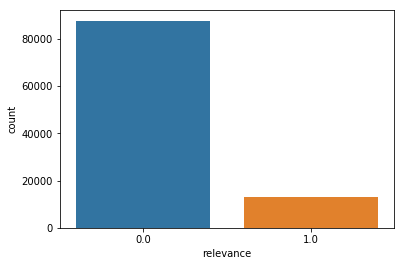

Negative Sampling Ratio: 6.632730300507153


In [11]:
#Test for negative sampling ratio, for this architecture a negative sampling ratio around 5.0 is very good
#based on the cited paper experiments https://arxiv.org/pdf/1708.05031.pdf
rel = (ml_df["relevance"] == 1.0).sum()
non_rel = (ml_df["relevance"] != 1.0).sum()

sns.countplot(x="relevance", data=ml_df)
plt.show()
print("Negative Sampling Ratio: " + str(non_rel / rel))

In [0]:
#Split dataset between train, eval and test
full_df = ml_df
eval_df = full_df.sample(frac=0.05)
full_df = full_df.drop(eval_df.index)
test_df = full_df.sample(frac=0.05)
train_df = full_df.drop(test_df.index)

In [13]:
#Store number of datapoints in each dataset
train_count = train_df.shape[0]
eval_count = eval_df.shape[0]
test_count = test_df.shape[0]
print("Train samples: " + str(train_count))
print("Evaluation samples: " + str(eval_count))
print("Test samples: " + str(test_count))

Train samples: 91004
Evaluation samples: 5042
Test samples: 4790


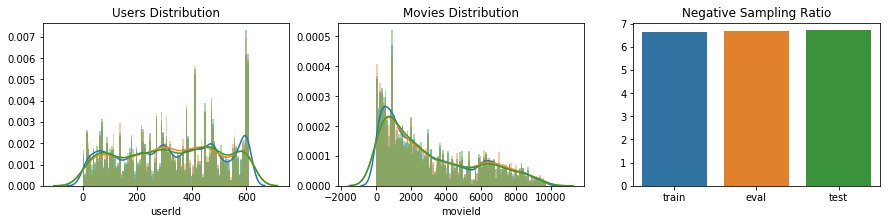

In [14]:
#Verify the distribution of the three splits
plt.figure(figsize=(15, 3))

#Verify users distributions
plt.subplot(1, 3, 1)
sns.distplot(a=train_df["userId"], bins=100).set_title("Users Distribution")
sns.distplot(a=eval_df["userId"], bins=100)
sns.distplot(a=test_df["userId"], bins=100)

#Verify movies distributions
plt.subplot(1, 3, 2)
sns.distplot(a=train_df["movieId"], bins=100).set_title("Movies Distribution")
sns.distplot(a=eval_df["movieId"], bins=100)
sns.distplot(a=test_df["movieId"], bins=100)


#Verify Negative Sampling Ration Between the splits
plt.subplot(1, 3, 3)
train_nsr = (train_df["relevance"] == 0.0).sum() / (train_df["relevance"] == 1.0).sum()
eval_nsr = (eval_df["relevance"] == 0.0).sum() / (eval_df["relevance"] == 1.0).sum()
test_nsr = (test_df["relevance"] == 0.0).sum() / (test_df["relevance"] == 1.0).sum()
sns.barplot(x=["train", "eval", "test"], y=[train_nsr, eval_nsr, test_nsr]).set_title("Negative Sampling Ratio")

plt.show()


Now that all the splits are balanced, let create the Tensorflow Datasets used for the training input pipeline

In [0]:
#Create Datasets for train, evaluation and testing
train_ds = tf.data.Dataset.from_tensor_slices(({"userId":train_df["userId"], "movieId":train_df["movieId"]}, train_df["relevance"].values.reshape([-1, 1]))).shuffle(4196)
eval_ds = tf.data.Dataset.from_tensor_slices(({"userId":eval_df["userId"], "movieId":eval_df["movieId"]}, eval_df["relevance"].values.reshape([-1, 1]))).batch(eval_count)
test_ds = tf.data.Dataset.from_tensor_slices(({"userId":test_df["userId"], "movieId":test_df["movieId"]}, test_df["relevance"].values.reshape([-1, 1]))).batch(test_count)

## Generalized Matrix Factorization

On this section we will implement the GMF described [on this paper](https://arxiv.org/pdf/1708.05031.pdf).  This generalization introduces non-linearities and change dot product by element-wise product. Check the paper on GMF section for more details. I will write this model with reusability on mind, so you will be able to pick this and use it on your implementations easily. I will create a repo for this implementation later.

In [0]:
class DenseBlock(tf.keras.layers.Layer):
  """
  Dense Block Unit

  Features Batch Normalization, Dropout and Dense layers, in that order
  Created for convenient building of Deep Feedforward Networks

  Args:
    units (int): Number of units on Dense Layer
    dropout (float): % of inputs to drop from Batch Normalization Layer
    l2 (float): Strenght of L2 regularization on Dense Layer

  """

  def __init__(self, units, activation="relu", dropout=0.1, l2=0.001):
    super(DenseBlock, self).__init__()

    self.bn = tf.keras.layers.BatchNormalization()
    self.drop = tf.keras.layers.Dropout(dropout)
    self.dense = tf.keras.layers.Dense(units, 
                                       activation,
                                       kernel_regularizer=tf.keras.regularizers.L1L2(l2=l2),
                                       kernel_constraint=tf.keras.constraints.UnitNorm())
    
  def call(self, inputs):
    X = self.bn(inputs)
    X = self.drop(X)
    X = self.dense(X)
    return X

In [0]:
class GeneralizedMatrixFactorizer(tf.keras.Model):
  """
  Generalized Matrix Factorization Model 

  Element-wise Product of Embeddings instead of Dot Product
  Non-Linear Activation Capability

  Args:
    alpha_dim (int): Number of rows of alpha Embedding Matrix, on movie recommend, can be the max number of users
    beta_dim (int): Number of rows of beta Embedding Matrix, on movie recommend, can be the max number of movies
    latent_dim (int): Dimension of the latent space representation of both Embedding Layers
    output_dim (int): Dimension of the model output
    output_activation (str): Activation function to be used on the last layer of the model, default="sigmoid"
    use_bias (bool): If allow the model to use bias for embeddings, default=False
    dropout (float): % of inputs to drop before output dense layer
    l2 (float): Strenght of L2 regularization on embeddings and output dense layer
    alpha_key (str): Key name in the call() input dictionary assigned to alpha, default="alpha"
    beta_key (str): Key name in the call() input dictionary assigned to beta, default="beta"

  """

  def __init__(self, 
               alpha_dim, 
               beta_dim, 
               latent_dim,
               output_dim,
               output_activation="sigmoid",
               use_bias=False, 
               dropout=0.1, 
               l2=1e-5, 
               alpha_key="alpha", 
               beta_key="beta"):
    
    super(GeneralizedMatrixFactorizer, self).__init__()

    self.use_bias = use_bias
    self.alpha_key = alpha_key
    self.beta_key = beta_key

    self.alpha_emb = tf.keras.layers.Embedding(alpha_dim, latent_dim, embeddings_regularizer=tf.keras.regularizers.L1L2(l2=l2))
    self.beta_emb = tf.keras.layers.Embedding(beta_dim, latent_dim, embeddings_regularizer=tf.keras.regularizers.L1L2(l2=l2))

    if(use_bias):
      self.alpha_bias = tf.keras.layers.Embedding(alpha_dim, 1)
      self.beta_bias = tf.keras.layers.Embedding(beta_dim, 1)
    
    self.flat = tf.keras.layers.Flatten()
    self.mul = tf.keras.layers.Multiply()
    self.out = DenseBlock(output_dim, output_activation, dropout, l2)

  def call(self, inputs):
    """
    Model Call

    Args:
      inputs (dict): Python dictionary with two keys, one for alpha and one for beta

    Return:
      Model output using current weights

    """
    alpha_emb = self.alpha_emb(inputs[self.alpha_key])
    alpha_emb = self.flat(alpha_emb)
    beta_emb = self.beta_emb(inputs[self.beta_key])
    beta_emb = self.flat(beta_emb)

    X = self.mul([alpha_emb, beta_emb])

    if(self.use_bias):
      alpha_bias = self.alpha_bias(inputs[self.alpha_key])
      alpha_bias = self.flat(alpha_bias)
      beta_bias = self.beta_bias(inputs[self.beta_key])
      beta_bias = self.flat(beta_bias)
      bias = tf.add(alpha_bias, beta_bias)
      X = tf.add(X, bias)

    X = self.out(X)
    return X

In [0]:
#Hyper-parameters
gmf_params = {"alpha_dim":n_users,
              "beta_dim":n_movies,
              "latent_dim":8,
              "output_dim":1,
              "output_activation":"sigmoid",
              "use_bias":False,
              "dropout":0.0,
              "l2":1e-3,
              "learning_rate":4e-4,
              "batch_size":256,
              "epochs":50}

In [0]:
#Instantiation
gmf = GeneralizedMatrixFactorizer(alpha_dim=gmf_params["alpha_dim"], 
                                  beta_dim=gmf_params["beta_dim"], 
                                  latent_dim = gmf_params["latent_dim"], 
                                  output_dim=gmf_params["output_dim"], 
                                  output_activation=gmf_params["output_activation"],
                                  use_bias=gmf_params["use_bias"],
                                  dropout=gmf_params["dropout"],
                                  l2=gmf_params["l2"], 
                                  alpha_key="userId", 
                                  beta_key="movieId")

gmf.compile(tf.keras.optimizers.Adam(gmf_params["learning_rate"]), 
            tf.keras.losses.BinaryCrossentropy(), 
            metrics=[tf.keras.metrics.BinaryAccuracy()])

In [22]:
#Fitting
gmf.fit(train_ds.batch(gmf_params["batch_size"]), 
        epochs=gmf_params["epochs"], 
        validation_data=eval_ds, 
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


356/356 [==============================] - 6s 17ms/step - loss: 0.6212 - binary_accuracy: 0.8555 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/50
356/356 [==============================] - 3s 8ms/step - loss: 0.4917 - binary_accuracy: 0.8689 - val_loss: 0.4529 - val_binary_accuracy: 0.8695
Epoch 3/50
356/356 [==============================] - 3s 8ms/step - loss: 0.4313 - binary_accuracy: 0.8689 - val_loss: 0.4138 - val_binary_accuracy: 0.8695
Epoch 4/50
356/356 [==============================] - 3s 8ms/step - loss: 0.4053 - binary_accuracy: 0.8689 - val_loss: 0.3975 - val_binary_accuracy: 0.8695
Epoch 5/50
356/356 [==============================] - 3s 7ms/step - loss: 0.3945 - binary_accuracy: 0.8689 - val_loss: 0.3907 - val_binary_accuracy: 0.8695
Epoch 6/50
356/356 [==============================] - 3s 8ms/step - loss: 0.3887 - binary_accuracy: 0.8689 - val_loss: 0.3856 - val_binary_accuracy: 0.8695
Epoch 7/50
356/356 [==============================] - 3s 8ms/step 

In [0]:
gmf.evaluate(test_ds)

1/1 [==============================] - 0s 15ms/step - loss: 0.3438 - binary_accuracy: 0.8839


[0.3438417613506317, 0.88392484]

In [0]:
#Save weights for use later
path = "./drive/My Drive/NeuralMatrixFactorization/Checkpoints/GMF/"
name = wandb.run.name

if(not os.path.exists(path + name)):
  os.mkdir(path + name)
  gmf.save_weights(path + name + "/checkpoint")

In [0]:
#Copy Checkpints folder to local
!cp -r "./drive/My Drive/NeuralMatrixFactorization/Checkpoints" "."

## Neural Collaborative Filtering
Now we will implement the Multi Layer Perceptron Portion of the NeuMF Architecture. This is very straighforward, visit [the paper](https://arxiv.org/pdf/1708.05031.pdf) for details

In [0]:
class DeepFeedForward(tf.keras.Model):
  """
  Plain Multi-Layer Perceptron

  Args:
    layers (int): Rank 1 array-like object describing the hiden units of each layer of the Model, 
                  the number of elements in this array will be the number of layers in the model
    dropout (float): Dropout rate of the layers
    l2 (float): L2 regularization strenght of all the layers

  """

  def __init__(self, layers, dropout=0.1, l2=0.001):
    super(DeepFeedForward, self).__init__()

    self.block_list = list()
    for layer in layers:
      self.block_list.append(DenseBlock(layer, "relu", dropout, l2))
    
  def call(self, inputs):

    X = inputs
    for layer in self.block_list:
      X = layer(X)
    return X

In [0]:
class NCFNetwork(tf.keras.Model):
  """
  Neural Collaborative Filtering

  Args:
    alpha_dim (int): Number of rows of alpha Embedding Matrix, on movie recommend, can be the max number of users
    beta_dim (int): Number of rows of beta Embedding Matrix, on movie recommend, can be the max number of movies
    latent_dim (int): Dimension of the latent space representation of both Embedding Layers
    layers (int): Rank 1 array-like object describing the hiden units in each layer of the MLP
    output_activation (str): Activation function to be used on the last layer of the model, default="sigmoid"
    use_bias (bool): If allow the model to use bias, default=False
    dropout (float): % of inputs to drop from Batch Normalization Layer
    l2 (float): Strenght of L2 regularization on Dense Layer
    alpha_key (str): Key name in the call() input dictionary assigned to alpha, default="alpha"
    beta_key (str): Key name in the call() input dictionary assigned to beta, default="beta"

  """

  def __init__(self, 
               alpha_dim, 
               beta_dim, 
               latent_dim, 
               layers, 
               output_activation="sigmoid",
               use_bias=False, 
               dropout=0.1, 
               l2=0.001, 
               alpha_key="alpha", 
               beta_key="beta"):
    
    super(NCFNetwork, self).__init__()

    self.alpha_key = alpha_key
    self.beta_key = beta_key
    self.use_bias = use_bias

    self.alpha_emb = tf.keras.layers.Embedding(alpha_dim, latent_dim, embeddings_regularizer=tf.keras.regularizers.L1L2(l2=l2))
    self.beta_emb = tf.keras.layers.Embedding(beta_dim, latent_dim, embeddings_regularizer=tf.keras.regularizers.L1L2(l2=l2))

    if(use_bias):
      self.alpha_bias = tf.keras.layers.Embedding(alpha_dim, 1)
      self.beta_bias = tf.keras.layers.Embedding(beta_dim, 1)
    
    self.flat = tf.keras.layers.Flatten()
    self.feedforward = DeepFeedForward(layers[:-1], dropout, l2)
    self.dense_out = DenseBlock(layers[-1], output_activation, dropout, l2)

  def call(self, inputs):

    alpha_emb = self.flat(self.alpha_emb(inputs[self.alpha_key]))
    beta_emb = self.flat(self.beta_emb(inputs[self.beta_key]))
    X = tf.concat([alpha_emb, beta_emb], axis=-1)

    if(self.use_bias):
      alpha_bias = self.flat(self.alpha_bias(inputs[self.alpha_key]))
      beta_bias = self.flat(self.beta_bias(inputs[self.beta_key]))
      bias = tf.add(alpha_bias, beta_bias)
      X = tf.add(X, bias)

    X = self.feedforward(X)
    X = self.dense_out(X)
    return X

In [0]:
#Hyper-params
ncf_params = {"alpha_dim":n_users,
              "beta_dim":n_movies,
              "latent_dim":1,
              "layers":[1],
              "output_activation":"sigmoid",
              "use_bias":False,
              "dropout":0.0,
              "l2":1e-8,
              "learning_rate":1e-4,
              "batch_size":256,
              "epochs":50}

In [0]:
#Instantiation
ncf = NCFNetwork(alpha_dim=ncf_params["alpha_dim"], 
                 beta_dim=ncf_params["beta_dim"], 
                 latent_dim=ncf_params["latent_dim"], 
                 layers=ncf_params["layers"],
                 output_activation=ncf_params["output_activation"],
                 use_bias=ncf_params["use_bias"],
                 dropout=ncf_params["dropout"], 
                 l2=ncf_params["l2"], 
                 alpha_key="userId",
                 beta_key="movieId")

ncf.compile(tf.keras.optimizers.Adam(ncf_params["learning_rate"]), 
            tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()])

In [35]:
#Fitting
ncf.fit(train_ds.batch(ncf_params["batch_size"]), 
        epochs=ncf_params["epochs"], 
        validation_data=eval_ds, 
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


      1/Unknown - 1s 1s/step - loss: 0.7305 - binary_accuracy: 0.5430WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.199554). Check your callbacks.
356/356 [==============================] - 5s 14ms/step - loss: 0.7090 - binary_accuracy: 0.5439 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/50
356/356 [==============================] - 2s 7ms/step - loss: 0.6525 - binary_accuracy: 0.6296 - val_loss: 0.6234 - val_binary_accuracy: 0.6801
Epoch 3/50
356/356 [==============================] - 2s 7ms/step - loss: 0.6090 - binary_accuracy: 0.7014 - val_loss: 0.5916 - val_binary_accuracy: 0.7271
Epoch 4/50
356/356 [==============================] - 2s 7ms/step - loss: 0.5742 - binary_accuracy: 0.7504 - val_loss: 0.5620 - val_binary_accuracy: 0.7610
Epoch 5/50
356/356 [==============================] - 2s 7ms/step - loss: 0.5448 - binary_accuracy: 0.7836 - val_loss: 0.5364 - val_binary_accuracy: 0.7886
Epoch 6/50
356/356 [===============

In [36]:
ncf.evaluate(test_ds)

1/1 [==============================] - 0s 18ms/step - loss: 0.3047 - binary_accuracy: 0.8756


[0.3046729266643524, 0.8755741]

In [0]:
#Save weights for use later
path = "./drive/My Drive/NeuralMatrixFactorization/Checkpoints/NCF/"
name = wandb.run.name

if(not os.path.exists(path + name)):
  os.mkdir(path + name)

ncf.save_weights(path + name + "/checkpoint")

In [0]:
#Copy Checkpints folder to local
!cp -r "./drive/My Drive/NeuralMatrixFactorization/Checkpoints" "."

## Naural Matrix Factorization

Lets implement this hybrid architecture, described [here](https://arxiv.org/pdf/1708.05031.pdf). It features a parallel architecture between a generalization of classic Matrix Factorization called Generalized Matrix Factorization, and Deep Feedforward Network, both of them feeded by its own Embeddings pair for users and items. [Check the paper](https://arxiv.org/pdf/1708.05031.pdf) for more details.

In [0]:
class NeuMF(tf.keras.Model):
  """
  Neural Matrix Factorizer

  Args:
    alpha_dim (int): Number of rows of alpha Embedding Matrix, on movie recommend, can be the max number of users
    beta_dim (int): Number of rows of beta Embedding Matrix, on movie recommend, can be the max number of movies
    NCF_latent_dim (int): Dimension of the latent space representation of both Embedding Layers on NCFNetwork
    GMF_latent_dim (int): Dimension of the latent space representation of both Embedding Layers on GMF
    NCF_layers (int): Rank 1 array-like object describing the hiden units in each layer of the NCF's MLP
    GMF_output_dim (int): Dimension of the GMF output
    NeuMF_output_dim (int): Dimension of the NeuMF output
    NCF_output_activation (str): Activation function to be used on the last layer of NCF, default="relu"
    GMF_output_activation (str): Activation function to be used on the last layer of GMF, default="relu"
    NeuMF_output_activation (str): Activation function to be used on the last layer of NeuMF, default="sigmoid"
    output_weight (float): Weight the balance between NCF and GMF outputs, default=0.5
    use_bias (bool): If allow the model to use bias, default=False
    dropout (float): % of inputs to drop from DenseBloscks
    l2 (float): Strenght of L2 regularization
    alpha_key (str): Key name in the call() input dictionary assigned to alpha, default="alpha"
    beta_key (str): Key name in the call() input dictionary assigned to beta, default="beta"
  
  """

  def __init__(self, 
               alpha_dim, 
               beta_dim, 
               NCF_latent_dim, 
               GMF_latent_dim, 
               NCF_layers,
               GMF_output_dim, 
               NeuMF_output_dim,
               NCF_output_activation="relu",
               GMF_output_activation="relu",
               NeuMF_output_activation="sigmoid", 
               output_weight=0.5, 
               use_bias=False, 
               dropout=0.1, 
               l2=0.001, 
               alpha_key="alpha", 
               beta_key="beta"):
    
    super(NeuMF, self).__init__()

    self.output_weight = output_weight

    self.NCF = NCFNetwork(alpha_dim, 
                          beta_dim, 
                          NCF_latent_dim, 
                          NCF_layers, 
                          NCF_output_activation, 
                          use_bias, 
                          dropout, 
                          l2, 
                          alpha_key, 
                          beta_key)
    
    self.GMF = GeneralizedMatrixFactorizer(alpha_dim, 
                                           beta_dim, 
                                           GMF_latent_dim, 
                                           GMF_output_dim, 
                                           GMF_output_activation, 
                                           use_bias, 
                                           dropout, 
                                           l2, 
                                           alpha_key, 
                                           beta_key)
    
    self.dense_out = DenseBlock(NeuMF_output_dim, NeuMF_output_activation, dropout, l2)

  def call(self, inputs):
    ncf = self.NCF(inputs) * (1.0 - self.output_weight)
    gmf = self.GMF(inputs) * self.output_weight

    X = tf.concat([ncf, gmf], axis=-1)
    X = self.dense_out(X)
    return X

In [0]:
nmf_params = {"alpha_dim":n_users,
              "beta_dim":n_movies,
              "NCF_latent_dim":2, 
              "GMF_latent_dim":2, 
              "NCF_layers":[2, 1],
              "GMF_output_dim":1, 
              "NeuMF_output_dim":1,
              "output_weight":0.5,
              "use_bias":False,
              "dropout":0.0,
              "l2":0.0,
              "learning_rate":1e-3,
              "batch_size":256,
              "epochs":50}

In [0]:
#Instantiation
nmf = NeuMF(alpha_dim=nmf_params["alpha_dim"], 
            beta_dim=nmf_params["beta_dim"], 
            NCF_latent_dim=nmf_params["NCF_latent_dim"],
            GMF_latent_dim=nmf_params["GMF_latent_dim"],
            NCF_layers=nmf_params["NCF_layers"],
            GMF_output_dim=nmf_params["GMF_output_dim"],
            NeuMF_output_dim=nmf_params["NeuMF_output_dim"],
            output_weight=nmf_params["output_weight"],
            use_bias=nmf_params["use_bias"], 
            dropout=nmf_params["dropout"],
            l2=nmf_params["l2"], 
            alpha_key="userId", 
            beta_key="movieId")

nmf.compile(tf.keras.optimizers.Adam(nmf_params["learning_rate"]), 
            tf.keras.losses.BinaryCrossentropy(), 
            metrics=[tf.keras.metrics.BinaryAccuracy()])

In [47]:
#Fitting
nmf.fit(train_ds.batch(nmf_params["batch_size"]), 
        epochs=nmf_params["epochs"], 
        validation_data=eval_ds, 
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/50
      1/Unknown - 3s 3s/step - loss: 0.8049 - binary_accuracy: 0.5703WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.206720). Check your callbacks.
356/356 [==============================] - 8s 24ms/step - loss: 0.5933 - binary_accuracy: 0.7659 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/50
356/356 [==============================] - 4s 12ms/step - loss: 0.4151 - binary_accuracy: 0.8689 - val_loss: 0.3813 - val_binary_accuracy: 0.8695
Epoch 3/50
356/356 [==============================] - 4s 12ms/step - loss: 0.3580 - binary_accuracy: 0.8689 - val_loss: 0.3514 - val_binary_accuracy: 0.8695
Epoch 4/50
356/356 [==============================] - 4s 12ms/step - loss: 0.3335 - binary_accuracy: 0.8689 - val_loss: 0.3451 - val_binary_accuracy: 0.8695
Epoch 5/50
356/356 [==============================] - 4s 12ms/step - loss: 0.3185 - binary_accuracy: 0.8689 - val_loss: 0.3432 - val_binary_accuracy: 0.8695
Epoch 6/50
356/356 [

In [48]:
nmf.evaluate(test_ds)

1/1 [==============================] - 0s 20ms/step - loss: 0.3479 - binary_accuracy: 0.8701


[0.34793567657470703, 0.87014616]